In [30]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from os import listdir
from typing import Tuple, List, Dict, Generator, Any
from IPython.display import clear_output

In [31]:
classes = {
    (0, 0, 0): (0, '__background__'),
    (200, 0, 0): (1, 'industrial_land'),
    (250, 0, 150): (2, 'urban_residential'),
    (200, 150, 150): (3, 'rural_residential'),
    (250, 150, 150): (4, 'traffic_land'),
    (0, 200, 0): (5, 'paddy_field'),
    (150, 250, 0): (6, 'irrigated_land'),
    (150, 200, 150): (7, 'dry_cropland'),
    (200, 0, 200): (8, 'garden_land'),
    (150, 0, 250): (9, 'arbor_forest'),
    (150, 150, 250): (10, 'shrub_land'),
    (250, 200, 0): (11, 'natural_meadow'),
    (200, 200, 0): (12, 'artificial_meadow'),
    (0, 0, 200): (13, 'river'),
    (0, 150, 200): (14, 'lake'),
    (0, 200, 250): (15, 'pond'),
}

classes_by_id = dict()
for rgb, (id, name) in classes.items():
    classes_by_id[id] = (rgb, name)

In [32]:
def get_subimages_generator(
    image: Image.Image,
    subimage_size: Tuple[int, int, int]
) -> Generator[Image.Image, None, None]:
    for r in range(image.size[1] // subimage_size[1]):
        for c in range(image.size[0] // subimage_size[0]):
            yield image.crop(box=(
                c * subimage_size[0],
                r * subimage_size[1],
                (c + 1) * subimage_size[0],
                (r + 1) * subimage_size[1]
            ))

In [33]:
def save_dataset_subimages(classes_filter: Dict[Tuple[int, int, int], float]):
    
    if len(listdir('dataset/originals/')) > 0:
        return

    for i, filename in enumerate(listdir('data/image_RGB/')):
        basename = filename[:filename.find('.tif')]

        image = Image.open(fp=f'data/image_RGB/{basename}.tif').crop(box=(16, 40, 7200 - 16, 6800 - 40))
        image_labeled = Image.open(fp=f'data/label_15classes/{basename}_label.tif').crop(box=(16, 40, 7200 - 16, 6800 - 40))
        subimages = get_subimages_generator(image=image, subimage_size=(224,224))
        subimages_labeleds = get_subimages_generator(image=image_labeled, subimage_size=(224,224))

        for si, subimage in enumerate(subimages):
            subimage_labeled = next(subimages_labeleds)
            
            # classes filter
            do_continue = False
            subimage_labeled_colors_dict = {rgb: count for count, rgb in subimage_labeled.getcolors()}
            for rgb, min_percent in classes_filter.items():
                if rgb not in subimage_labeled_colors_dict \
                    or subimage_labeled_colors_dict[rgb] * 100 / 50176 < min_percent:
                    # 50176 = subimage width * subimage height
                    do_continue = True
                    break
            if do_continue:
                continue

            subimage.save(fp=f'dataset/originals/i{i}si{si}.tif')
            subimage_labeled.save(fp=f'dataset/labeleds/i{i}si{si}_labeled.tif')

In [34]:
save_dataset_subimages(
    classes_filter={
        (150, 250, 0): 5
    }
)

In [35]:
def get_dataset_subimage(dataset_subimage_id: str) -> Tuple[Image.Image, Image.Image]:

    subimage = Image.open(fp=f'dataset/originals/{dataset_subimage_id}.tif')
    subimage_labeled = Image.open(fp=f'dataset/labeleds/{dataset_subimage_id}_labeled.tif')

    return subimage, subimage_labeled

In [36]:
def get_image_mask_from_labeled(
    image_labeled: Image.Image,
    classes: Dict[Tuple[int, int, int], Tuple[int, str]]
) -> np.ndarray:

    image_mask = np.zeros(shape=(len(classes),image_labeled.size[0],image_labeled.size[1]))

    image_labeled_ndarray = np.array(object=image_labeled)
    for r in np.arange(stop=image_labeled_ndarray.shape[0]):
        for c in np.arange(stop=image_labeled_ndarray.shape[1]):
            class_rgb = tuple(image_labeled_ndarray[r][c])
            class_value = classes.get(class_rgb)
            if class_value != None:
                image_mask[class_value[0]][r][c] = 1.0
            else:
                image_mask[0][r][c] = 1.0

    return image_mask

In [37]:
def get_image_labeled_from_mask(
    image_mask: np.ndarray,
    classes_by_id: Dict[Tuple[int, int, int], Tuple[int, str]]
) -> Image.Image:

    image_labeled_ndarray = np.zeros(
        shape=(image_mask.shape[1],image_mask.shape[2],3),
        dtype=np.uint8
    )

    image_mask_hot = image_mask.argmax(axis=0)
    for r in np.arange(stop=image_mask_hot.shape[0]):
        for c in np.arange(stop=image_mask_hot.shape[1]):
            class_id = image_mask_hot[r][c]
            class_by_id_value = classes_by_id.get(class_id)
            image_labeled_ndarray[r][c] = np.array(object=class_by_id_value[0])
    
    image_labeled = Image.fromarray(obj=image_labeled_ndarray)
    
    return image_labeled

In [38]:
def image_preprocess(image: Image.Image) -> torch.Tensor:
    return torchvision.transforms.ToTensor()(pic=image)

In [39]:
def get_dataset_subimage_tensor(
    subimage: Image.Image,
    subimage_labeled: Image.Image,
    classes: Dict[Tuple[int, int, int], Tuple[int, str]],
    dtype: torch.FloatType = None,
) -> Tuple[torch.Tensor, torch.Tensor]:

    subimage_tensor = image_preprocess(image=subimage)
    subimage_mask_tensor = torch.tensor(
        data=get_image_mask_from_labeled(
            image_labeled=subimage_labeled,
            classes=classes
        ),
        dtype=dtype
    )

    return subimage_tensor, subimage_mask_tensor

In [40]:
subimage, subimage_labeled = get_dataset_subimage(dataset_subimage_id='i0si0')

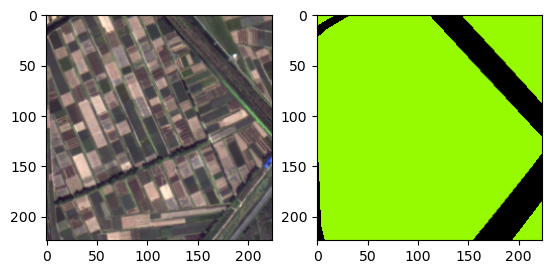

In [41]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(subimage)
ax[1].imshow(subimage_labeled)
plt.show()

In [42]:
subimage_mask = get_image_mask_from_labeled(
    image_labeled=subimage_labeled,
    classes=classes
)

In [43]:
subimage_labeled_from_mask = get_image_labeled_from_mask(
    image_mask=subimage_mask,
    classes_by_id=classes_by_id
)

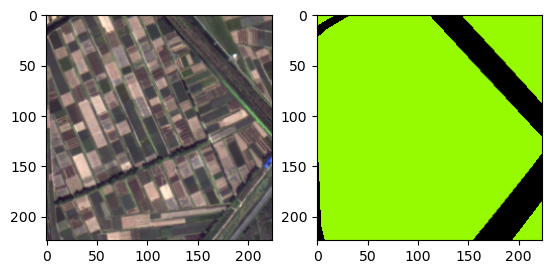

In [44]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(subimage)
ax[1].imshow(subimage_labeled_from_mask)
plt.show()

In [45]:
def get_dataset_subimages_id() -> List[str]:
    return [
        filename[:filename.find('.tif')]
        for filename in listdir(path='dataset/originals/')
    ]

In [46]:
train_dataset_subimages_id, test_dataset_subimages_id = train_test_split(get_dataset_subimages_id()[:1000], train_size=0.9)

In [47]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,
        dataset_subimages_id: List[str],
        classes: Dict[Tuple[int, int, int], Tuple[int, str]],
    ):
        self.dataset_subimages_id = dataset_subimages_id
        self.classes = classes
  
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        subimage = Image.open(fp=f'dataset/originals/{self.dataset_subimages_id[idx]}.tif')
        subimage_labeled = Image.open(fp=f'dataset/labeleds/{self.dataset_subimages_id[idx]}_labeled.tif')
        subimage_tensor, subimage_mask_tensor = get_dataset_subimage_tensor(
            subimage=subimage,
            subimage_labeled=subimage_labeled,
            classes=self.classes
        )
        return subimage_tensor, subimage_mask_tensor
  
    def __len__(self) -> int:
        return len(self.dataset_subimages_id)

In [48]:
train_dataset = Dataset(
    dataset_subimages_id=train_dataset_subimages_id,
    classes=classes,
)
test_dataset = Dataset(
    dataset_subimages_id=test_dataset_subimages_id,
    classes=classes
)

In [49]:
batch_size=16#32
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=1
)

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [51]:
model = torchvision.models.segmentation.fcn_resnet101(
    num_classes=len(classes),
    weights_backbone=torchvision.models.ResNet101_Weights.IMAGENET1K_V1
).to(device=device)

In [52]:
def predict(
    image: Image.Image,
    model: torch.nn.Module,
    device: torch.DeviceObjType,
) -> Image.Image:

    image_tensor = image_preprocess(image=image)

    with torch.no_grad():
        output_image_mask = model(image_tensor.unsqueeze(0).to(device))['out'][0].cpu().numpy()

    predicted_image_labeled = get_image_labeled_from_mask(
        image_mask=output_image_mask,
        classes_by_id=classes_by_id
    )

    return predicted_image_labeled

In [53]:
predicted_image_labeled = predict(
    image=subimage,
    model=model,
    device=device
)

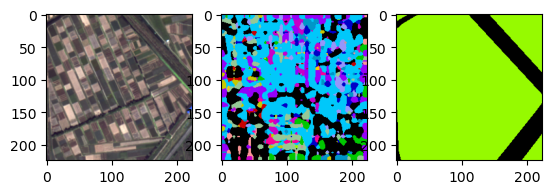

In [54]:
fig, ax = plt.subplots(ncols=3)
ax[0].imshow(subimage)
ax[1].imshow(predicted_image_labeled)
ax[2].imshow(subimage_labeled)
plt.show()

In [55]:
def metric_pixel_accuracy(
    y_pred: torch.Tensor,
    y_true: torch.Tensor
) -> float:

    y_pred_argmax = y_pred.argmax(dim=1)
    y_true_argmax = y_true.argmax(dim=1)

    correct_pixels = (y_pred_argmax == y_true_argmax).count_nonzero()
    uncorrect_pixels = (y_pred_argmax != y_true_argmax).count_nonzero()
    result = (correct_pixels / (correct_pixels + uncorrect_pixels)).item()

    return result

In [56]:
def metric_iou(
    y_pred: torch.Tensor,
    y_true: torch.Tensor
) -> float:

    y_pred_hot = y_pred >= 0.51

    intersection = torch.logical_and(y_pred_hot, y_true).count_nonzero()
    union = torch.logical_or(y_pred_hot, y_true).count_nonzero()
    result = (intersection / union).item()

    return result

In [57]:
def train(
    model: torch.nn.Module,
    device: torch.DeviceObjType,
    train_dataloader: torch.utils.data.DataLoader,
    loss_fn: Any,
    optim_fn: Any,
    epochs: int
) -> Dict[str, List[float]]:

    history_metrics = {
        'loss': list(),
        'pixel_accuracy': list(),
        'iou': list()
    }

    for e in range(1, epochs + 1):
        for b, data in enumerate(train_dataloader, start=1):
            subimage_tensor, subimage_mask_tensor = data

            if device.type == 'cuda':
                subimage_tensor = subimage_tensor.to(device)
                subimage_mask_tensor = subimage_mask_tensor.to(device)

            optim_fn.zero_grad()
            output = model(subimage_tensor)
            loss = loss_fn(output['out'], subimage_mask_tensor)
            loss.backward()
            optim_fn.step()

            loss_item = loss.item()
            pixel_accuracy = metric_pixel_accuracy(output['out'], subimage_mask_tensor)
            iou = metric_iou(output['out'], subimage_mask_tensor)

            history_metrics['loss'].append(loss_item)
            history_metrics['pixel_accuracy'].append(pixel_accuracy)
            history_metrics['iou'].append(iou)

            # dynamic output
            clear_output()
            print(
                'Epoch: {}. Batch: {}. Loss: {:.3f} | Pixel Accuracy: {:.3f} | IoU: {:.3f}'.format(
                    e, b,
                    loss, pixel_accuracy, iou
                )
            )

            # memory clear
            del subimage_tensor, subimage_mask_tensor, output, loss
            if device.type == 'cuda':
                torch.cuda.empty_cache()

    return history_metrics

In [58]:
epochs = 8#8
lr = 1e-3#1e-4
history_metrics = train(
    model=model,
    device=device,
    train_dataloader=train_dataloader,
    loss_fn=torch.nn.CrossEntropyLoss(),
    optim_fn=torch.optim.NAdam(params=model.parameters(), lr=lr),
    epochs=epochs,
)

Epoch: 8. Batch: 57. Loss: 0.431 | Pixel Accuracy: 0.852 | IoU: 0.477


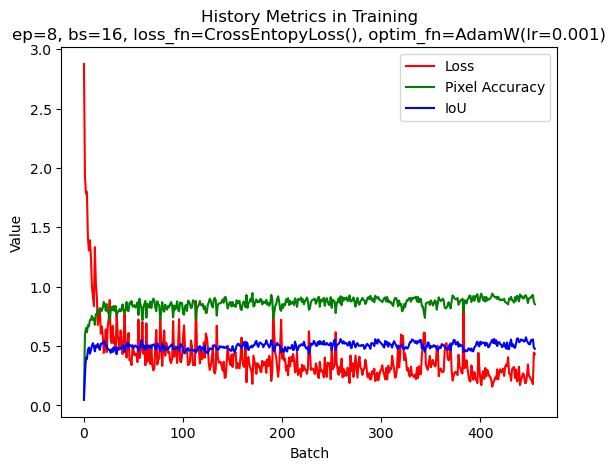

In [59]:
plt.plot(
    history_metrics['loss'], 'red',
    history_metrics['pixel_accuracy'], 'green',
    history_metrics['iou'], 'blue',
)
plt.title(f'History Metrics in Training\nep={epochs}, bs={batch_size}, loss_fn=CrossEntopyLoss(), optim_fn=AdamW(lr={lr})')
plt.xlabel('Batch')
plt.ylabel('Value')
plt.legend(('Loss', 'Pixel Accuracy', 'IoU'))
plt.show()

In [60]:
torch.save(
    model.state_dict(),
    f'remezova_fcn_resnet101_ep{epochs}bs{batch_size}lr{lr}.h5'
)

In [61]:
def test(
    model: torch.nn.Module,
    device: torch.DeviceObjType,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: Any,
) -> Dict[str, List[float]]:

    history_metrics = {
        'pixel_accuracy': list(),
        'iou': list()
    }

    for b, data in enumerate(test_dataloader, start=1):
        subimage_tensor, subimage_mask_tensor = data
        
        if device.type == 'cuda':
            subimage_tensor = subimage_tensor.to(device)
            subimage_mask_tensor = subimage_mask_tensor.to(device)
        
        with torch.no_grad():
            output = model(subimage_tensor)

        pixel_accuracy = metric_pixel_accuracy(output['out'], subimage_mask_tensor)
        iou = metric_iou(output['out'], subimage_mask_tensor)

        history_metrics['pixel_accuracy'].append(pixel_accuracy)
        history_metrics['iou'].append(iou)

        clear_output()
        print(
            'Batch: {}. median Pixel Accuracy: {:.3f} | median IoU: {:.3f}'.format(
                b,
                np.median(a=history_metrics['pixel_accuracy']),
                np.median(a=history_metrics['iou'])
            )
        )

        # memory clear
        del subimage_tensor, subimage_mask_tensor, output
        if device.type == 'cuda':
            torch.cuda.empty_cache()

    return history_metrics

In [62]:
test_history_metrics = test(
    model=model,
    device=device,
    test_dataloader=test_dataloader,
    loss_fn=torch.nn.CrossEntropyLoss()
)

Batch: 100. median Pixel Accuracy: 0.628 | median IoU: 0.413


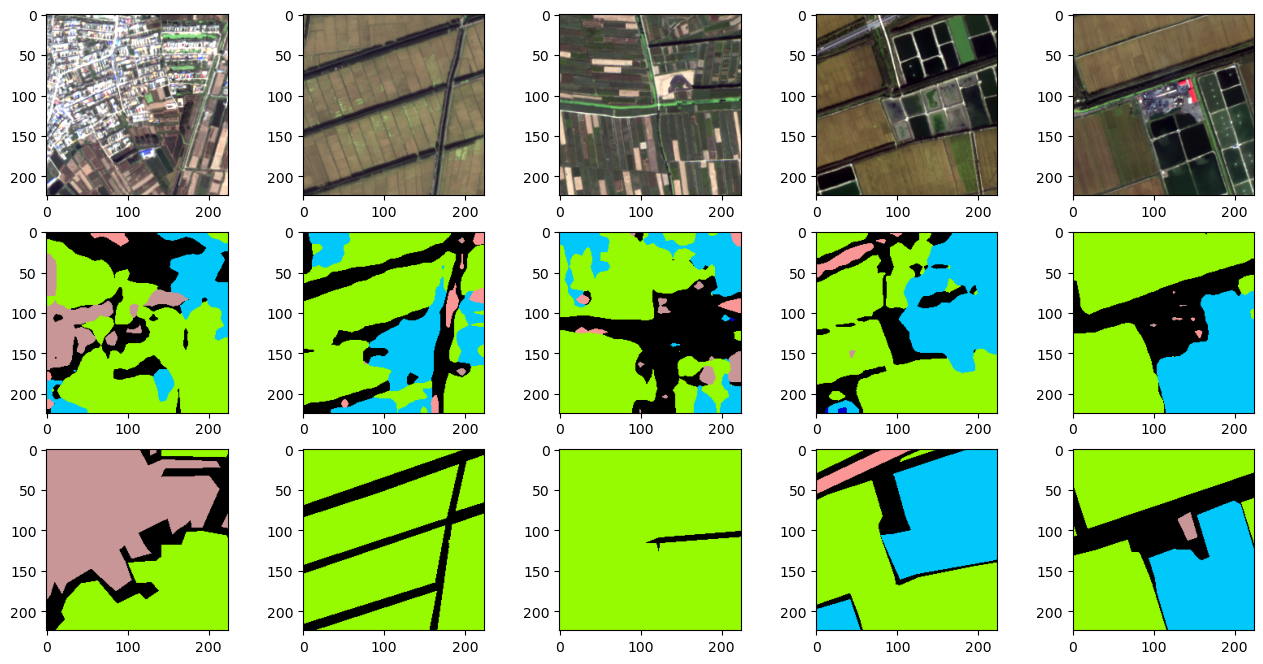

In [67]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(16,8))
for si, (subimage_tensor, subimage_mask_tensor) in enumerate(test_dataloader):
    subimage = torchvision.transforms.ToPILImage()(pic=subimage_tensor[0])
    subimage_labeled = get_image_labeled_from_mask(
        image_mask=subimage_mask_tensor[0].cpu().numpy(),
        classes_by_id=classes_by_id
    )
    predicted_subimage_labeled = predict(
        image=subimage,
        model=model,
        device=device
    )
    ax[0][si].imshow(subimage)
    ax[1][si].imshow(predicted_subimage_labeled)
    ax[2][si].imshow(subimage_labeled)
    
    if si == 5 - 1:
        break

plt.show()